# Probabilistic Programming Concepts

In [1]:
%matplotlib inline

import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook', font_scale=1.5)

## Bayes theorem and parameter estimation

In  general, the problem is set up like this:
    
- We have some observed outcomes $y$ that we want to model
- The model is formulated as a probability distribution with some parameters $\theta$ to be estimated 
- We want to estimate the posterior distribution of the model parameters given the data
$$
P(\theta \mid y) = \frac{P(y \mid \theta) \, P(\theta)}{\int P(y \mid \theta^*) \, P(\theta^*) \, d\theta^*}
$$
- For formulating a specification using probabilistic programming, it is often useful to think of how we would simulated a draw from the model

## Probabilistic Programming

Statistical objects of interest have the same form as the expectation
$$E[f(\theta)] = {\int f(\theta)p(\theta) d\theta}$$
For example, in addition to the marginal in the denominator of Bayes' theorem, the posterior predictive distribution is
$$p(\hat{y} \mid y) = {\int p(\hat{y} \mid \theta) p(\theta \mid y) d\theta}$$
Probabilistic programming is a way to encode such concepts so they can be automatically calculated

- DSL for model construction, inference and evaluation
- Inference Engines
- PyMC3, PyStan and Edward 2

## Estimating integrals

Integration problems are common in statistics whenever we are dealing with continuous distributions. For example the expectation of a function is an integration problem

$$
E[f(x)] = \int{f(x) \, p(x) \, dx}
$$

In Bayesian statistics, we need to solve the integration problem for the marginal likelihood or evidence

$$
p(X \mid \alpha) = \int{p(X \mid \theta) \, p(\theta \mid \alpha) d\theta}
$$

where $\alpha$ is a hyperparameter and $p(X \mid \alpha)$ appears in the denominator of Bayes theorem

$$
p(\theta | X) = \frac{p(X \mid \theta) \, p(\theta \mid \alpha)}{p(X \mid \alpha)}
$$

In general, there is no closed form solution to these integrals, and we have to approximate them numerically. The first step is to check if there is some **reparameterization** that will simplify the problem. Then, the general approaches to solving integration problems are

1. Numerical quadrature
2. Importance sampling, adaptive importance sampling and variance reduction techniques (Monte Carlo swindles)
3. Markov Chain Monte Carlo
4. Asymptotic approximations (Laplace method and its modern version in variational inference)

This lecture will review the concepts for quadrature and Monte Carlo integration.

## Numerical integration (Quadrature)

You may recall from Calculus that integrals can be numerically evaluated using quadrature methods such as Trapezoid and Simpson's's rules. This is easy to do in Python, but has the drawback of the complexity growing as $O(n^d)$ where $d$ is the dimensionality of the data, and hence infeasible once $d$ grows beyond a modest number.

### Integrating functions

In [2]:
from scipy.integrate import quad

In [3]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

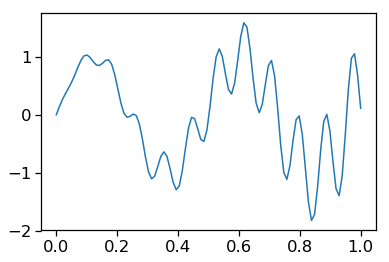

In [4]:
x = np.linspace(0, 1, 100)
plt.plot(x, f(x))
pass

#### Exact solution

In [5]:
from sympy import sin, cos, symbols, integrate

x = symbols('x')
integrate(x * cos(71*x) + sin(13*x), (x, 0,1)).evalf(6)

0.0202549

#### Using quadrature

In [6]:
y, err = quad(f, 0, 1.0)
y

0.02025493910239419

#### Multiple integration

Following the `scipy.integrate` [documentation](http://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html), we integrate

$$
I=\int_{y=0}^{1/2}\int_{x=0}^{1-2y} x y \, dx\, dy
$$

In [7]:
x, y = symbols('x y')
integrate(x*y, (x, 0, 1-2*y), (y, 0, 0.5))

0.0104166666666667

In [8]:
from scipy.integrate import nquad

def f(x, y):
    return x*y

def bounds_y():
    return [0, 0.5]

def bounds_x(y):
    return [0, 1-2*y]

y, err = nquad(f, [bounds_x, bounds_y])
y

0.010416666666666668

## Curse of dimensionality and concentration of measure

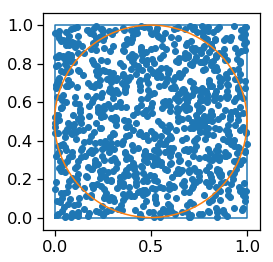

In [9]:
plt.plot([0,1,1,0,0], [0,0,1,1,0])
θ = np.linspace(0, 2*np.pi, 100)
plt.scatter(np.random.rand(1000), np.random.rand(1000))
plt.plot(0.5+0.5*np.cos(θ), 0.5+0.5*np.sin(θ))
plt.axis('square')
pass

Suppose we inscribe an $d$-dimensional sphere in a $d$-dimensional cube. What happens as $n$ grows large?

The volume of a $d$-dimensional unit sphere is

$$V = \frac{\pi^{\frac{d}{2}}}{\frac{d}{2} \Gamma(\frac{d}{2})}$$

The Gamma function has a factorial growth rate, and hence as $d \to \infty$, $V(d) \to 0$.

In fact, for a sphere of radius $r$, as $d \to infty$, almost all the volume is contained in an annulus of width $r/d$ near the boundary of the sphere. And since the volume of the unit sphere goes to 0 while the volume of unit sphere is constant at 1 while $d$ goes to infinity, essentially all the volume is contained in the corners outside the sphere. 

For more explanation of why this matters, see this [doc](https://www.math.ucdavis.edu/~strohmer/courses/180BigData/180lecture1.pdf)

## Working with random variables

See [notebook S14B](S14B_Random_Variables.ipynb)

## Monte Carlo methods

See [notebook S14C](S14C_Monte_Carlo_Methods.ipynb)

## Monte Carlo integration

See [notebook S14D](S14D_Monte_Carlo_Integration.ipynb)

## Drawing pictures

### DBDA diagrams

- [Using LaTeX](https://github.com/tinu-schneider/DBDA_hierach_diagram)
- [Using R and LibreOffice](https://github.com/rasmusab/distribution_diagrams)

Example

![img](https://camo.githubusercontent.com/461d1c11baae73b680b14f10709551fa2f28be1b/68747470733a2f2f7261772e6769746875622e636f6d2f74696e752d7363686e65696465722f444244415f686965726163685f6469616772616d2f6d61737465722f4578616d706c652e706e67)

### Plate diagrams

- [Using `daft`](http://daft-pgm.org)

In [10]:
import daft

#### Coin toss model

In [11]:
pgm = daft.PGM(shape=[2.5, 3.0], origin=[0, -0.5])

pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2, fixed=True))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2, fixed=True))
pgm.add_node(daft.Node("p", r"$p$", 1, 1))
pgm.add_node(daft.Node("n", r"$n$", 2, 0, fixed=True))
pgm.add_node(daft.Node("y", r"$y$", 1, 0, observed=True))

pgm.add_edge("alpha", "p")
pgm.add_edge("beta", "p")
pgm.add_edge("n", "y")
pgm.add_edge("p", "y")

pgm.render()
plt.close()
pgm.figure.savefig("bias.png", dpi=300)
pass

In [12]:
from IPython.display import Image

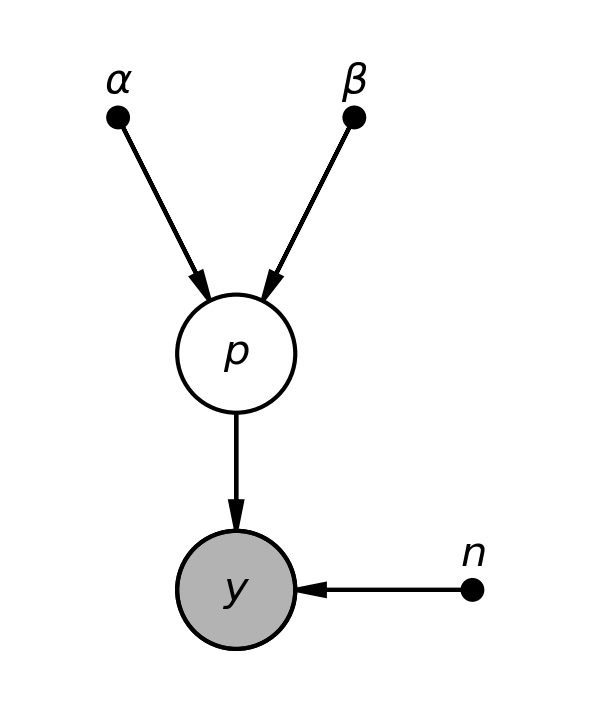

In [13]:
Image("bias.png", width=400)

#### Linear regression model

In [14]:
# Instantiate the PGM.
pgm = daft.PGM(shape=[4.0, 3.0], origin=[-0.3, -0.7])

# Hierarchical parameters.
pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2))
pgm.add_node(daft.Node("sigma", r"$\sigma$", 0, 0))

# Deterministic variable.
pgm.add_node(daft.Node("mu", r"$\mu_n$", 1, 1))

# Data.
pgm.add_node(daft.Node("x", r"$x_n$", 2, 1, observed=True))
pgm.add_node(daft.Node("y", r"$y_n$", 1, 0, observed=True))

# Add in the edges.
pgm.add_edge("alpha", "mu")
pgm.add_edge("beta", "mu")
pgm.add_edge("x", "mu")
pgm.add_edge("mu", "y")
pgm.add_edge("sigma", "y")

# And a plate.
pgm.add_plate(daft.Plate([0.5, -0.5, 2, 2], label=r"$n = 1, \cdots, N$",
    shift=-0.1, rect_params={'color': 'white'}))

# Render and save.
pgm.render()
plt.close()
pgm.figure.savefig("lm.png", dpi=300)

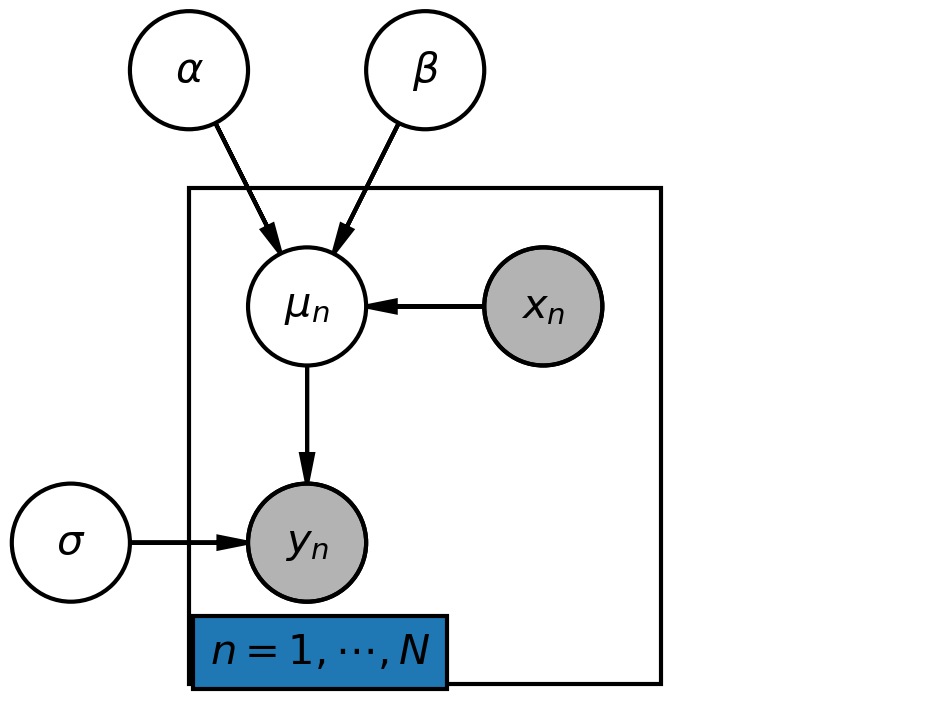

In [15]:
Image(filename="lm.png", width=400)